In [1]:
# 주요 라이브러리 import
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

In [3]:
# 데이터 로드
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [4]:
# 데이터 전처리 함수
def preprocess_data(df):
    df = df.copy()
    df.dropna(axis=1, how='all', inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    
    # 수치형 열 처리
    numeric_imputer = SimpleImputer(strategy='median')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    # 범주형 열 처리
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    
    # 극단값 처리 (기존 코드 유지)
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    
    # 정수형 열 처리
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df[col] = df[col].round().astype('int64')
    
    return df

In [5]:
# 데이터 전처리 적용
train_data_processed = preprocess_data(train_data)

In [6]:
# train_data_processed 확인
print("Train data demo shape:", train_data_processed.shape)
print("\nTrain data demo preview:")
print(train_data_processed.head())
print("\nTrain data demo info:")
train_data_processed.info()
train_data_processed

Train data demo shape: (40506, 186)

Train data demo preview:
  Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

  Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0    4F1XA938-1                1.0                  OK   
1    3KPM0016-2                1.0                  OK   
2    4E1X9167-1                1.0                  OK   
3    3K1X0057-1                1.0                  OK   
4    3HPM0007-1                1.0                  OK   

   CURE END POSITION X Collect Result_Dam  \
0                                   240.0   
1                                   240.0   
2                          

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1.0,OK,240.0,2.5,-90.0,...,50.0,91.8,270.0,50.0,114.612,19.9,7.0,127.0,1.0,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1.0,OK,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.600,7.0,185.0,1.0,0.0,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1.0,OK,1000.0,12.5,90.0,...,50.0,91.8,270.0,50.0,114.612,19.8,10.0,73.0,1.0,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1.0,OK,1000.0,12.5,90.0,...,91.8,270.0,50.0,85.0,19.900,12.0,268.0,1.0,0.0,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1.0,OK,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.700,8.0,121.0,1.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1.0,OK,240.0,2.5,-90.0,...,91.8,270.0,50.0,85.0,19.200,1.0,289.5,1.0,0.0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1.0,OK,1000.0,12.5,90.0,...,50.0,91.8,270.0,50.0,114.612,20.5,14.0,197.0,1.0,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1.0,OK,240.0,2.5,-90.0,...,50.0,91.8,270.0,50.0,85.000,19.7,1.0,27.0,1.0,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1.0,OK,1000.0,12.5,90.0,...,91.8,270.0,50.0,85.0,20.100,13.0,117.0,1.0,0.0,Normal


In [7]:
# 레이블 인코딩
le = LabelEncoder()
y = le.fit_transform(train_data_processed['target'])

In [8]:
# 특성 선택
features = train_data_processed.drop('target', axis=1).select_dtypes(include=[np.number]).columns
X = train_data_processed[features]
y = le.fit_transform(train_data_processed['target'])

In [9]:
# 전체 데이터셋에 대한 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# PCA 객체 생성 (모든 주성분 유지)
pca_full = PCA(n_components=min(X_scaled.shape), random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

PCA(n_components=149, random_state=110)

In [11]:
# 누적 설명 분산 비율과 Eigenvalue 계산
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
eigenvalues = pca_full.explained_variance_

Text(0.5, 1.0, 'Scree Plot with Cumulative Variance Ratio and Eigenvalues')

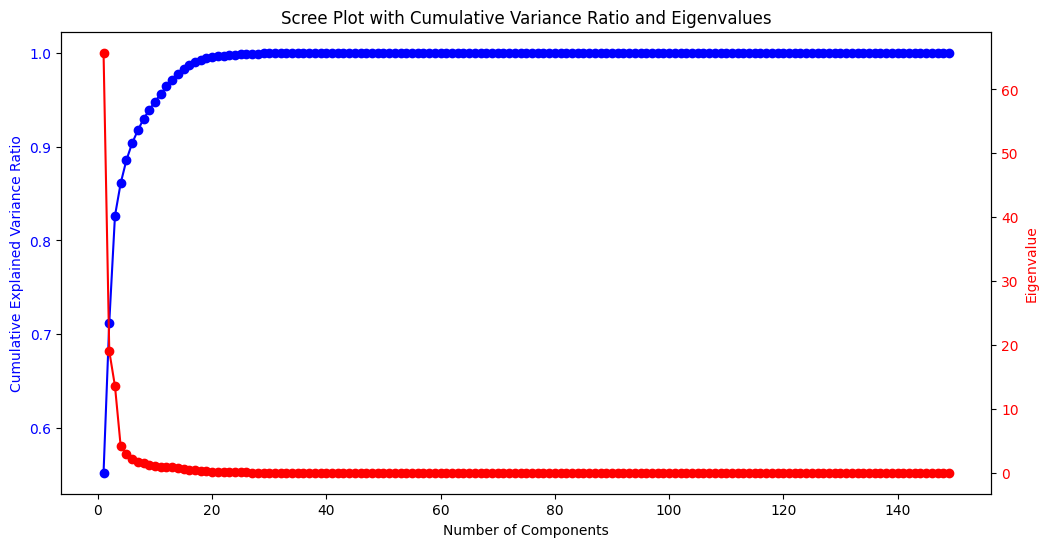

In [12]:
# Scree plot 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 누적 설명 분산 비율 플롯 (왼쪽 y축)
ax1.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Eigenvalue 플롯 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ro-')
ax2.set_ylabel('Eigenvalue', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Scree Plot with Cumulative Variance Ratio and Eigenvalues')

In [36]:
# 99% 설명 분산에 해당하는 주성분 개수 찾기
n_components_99 = next(i for i, ratio in enumerate(cumulative_variance_ratio) if ratio >= 0.99) + 1
ax1.axhline(y=0.95, color='g', linestyle='--')
ax1.axvline(x=n_components_99, color='g', linestyle='--')
ax1.text(n_components_99, 0.5, f'99% variance at {n_components_99} components', color='g')

Text(18, 0.5, '99% variance at 18 components')

In [14]:
# Kaiser criterion (Eigenvalue > 1) 표시
kaiser_components = sum(eigenvalues > 1)
ax2.axhline(y=1, color='purple', linestyle='--')
ax2.text(kaiser_components + 1, 1.5, f'Kaiser criterion\nat {kaiser_components} components', color='purple')

plt.show()

print(f"Number of components for 99% explained variance: {n_components_99}")
print(f"Number of components with Eigenvalue > 1 (Kaiser criterion): {kaiser_components}")

Number of components for 99% explained variance: 18
Number of components with Eigenvalue > 1 (Kaiser criterion): 10


In [15]:
# 선택된 주성분 개수로 PCA 수행
pca = PCA(n_components=n_components_99, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after PCA: {X_pca.shape[1]}")

Original number of features: 149
Number of features after PCA: 18


In [16]:
# PCA가 적용된 데이터를 훈련셋과 검증셋으로 나누기
X_train_pca, X_val_pca, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

In [17]:
# 훈련셋에 대해 SMOTE 적용
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("After SMOTE:")
print(f"Train set - Normal: {sum(y_train_resampled == 0)}, AbNormal: {sum(y_train_resampled == 1)}")

After SMOTE:
Train set - Normal: 26709, AbNormal: 26709


In [18]:
# 각 모델의 하이퍼파라미터 탐색 공간 정의
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_split_gain': [0, 0.1, 0.2]
}

catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

f1_scorer = make_scorer(f1_score, pos_label='AbNormal')

In [19]:
# RandomizedSearchCV를 이용한 모델 최적화
def optimize_model(model, params, X, y):
    random_search = RandomizedSearchCV(
        model, 
        params, 
        n_iter=20,
        cv=5,
        n_jobs=-1,
        scoring='neg_log_loss',  # log_loss를 사용하여 NaN 방지
        random_state=RANDOM_STATE,
        error_score='raise'  # 에러 발생 시 즉시 중단
    )
    random_search.fit(X, y)
    return random_search.best_estimator_

In [20]:
# 각 모델 정의
xgb = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', enable_categorical=True)
lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)  # verbose=-1로 설정하여 경고 메시지 억제
catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

In [21]:
# 각 모델 최적화
xgb_optimized = optimize_model(xgb, xgb_params, X_train_resampled, y_train_resampled)

In [22]:
lgbm_optimized = optimize_model(lgbm, lgbm_params, X_train_resampled, y_train_resampled)

In [23]:
catboost_optimized = optimize_model(catboost, catboost_params, X_train_resampled, y_train_resampled)

In [24]:
# Stacking 앙상블 모델 구축
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_optimized),
        ('lgbm', lgbm_optimized),
        ('catboost', catboost_optimized)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [25]:
# 앙상블 모델 학습
stacking_model.fit(X_train_resampled, y_train_resampled)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=110, ...)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.9,
                                               max_depth=5,
                                               min_child_samples=100,
                                               min_split_gain=0.2,
                                               n_estimators=300,
                                               random_state=110, reg_alpha=0,
                                               reg_lambda=0.5, verbose=-1)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001A0248EF610>)],
                   final_estimator=LogisticRegression())

In [26]:
# 검증 세트에 대한 예측
y_val_pred_ensemble = stacking_model.predict(X_val_pca)

In [28]:
# 모델 성능 평가
abnormal_label_index = list(le.classes_).index('AbNormal')
f1 = f1_score(y_val, y_val_pred_ensemble, pos_label=abnormal_label_index)
print("Model Validation F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_ensemble, target_names=le.classes_))

Model Validation F1 Score: 0.15604938271604937

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.12      0.22      0.16       705
      Normal       0.95      0.90      0.92     11447

    accuracy                           0.86     12152
   macro avg       0.53      0.56      0.54     12152
weighted avg       0.90      0.86      0.88     12152



In [29]:
# f1-Score:0.15604938271604937 (Validation Set)

In [30]:
# 테스트 데이터 불러오기 및 전처리
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data_processed = preprocess_data(test_data)
test_X = test_data_processed[features]
test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

In [31]:
# 예측
test_pred = stacking_model.predict(test_X_pca)
test_pred_labels = le.inverse_transform(test_pred)

In [32]:
# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred_labels

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [33]:
# 예측 결과 확인
print("\n예측된 레이블 분포:")
print(pd.Series(test_pred_labels).value_counts())


예측된 레이블 분포:
Normal      15482
AbNormal     1879
Name: count, dtype: int64


In [34]:
# test set f1-score: 0.15611